## E12. Movielens 영화 SBR
Session-based recommendation이란 session data를 기반으로 다음에 클릭 또는 구매할 아이템을 예측하는 추천시스템이다.     
이 프로젝트에서는 영화리뷰 데이터를 분석해서 user의 다음영화를 예측하는 모델을 만들어보았다. 

### 필요한 모듈 불러오기

In [1]:
import os
import pandas as pd
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

### 데이터 가져오기
* README에 따르면 이 데이터는 MovieLens사이트에서 2000년에 회원이 된 6,040 명의 user들이 3,900개의 영화에 대해서 평가한 1,000,209개의 익명의 rating. 
* 데이터에는 4개의 column이 있다 (UserID, MovieId, Ratings, Timestamp). 
    - UserIDs range between 1 and 6040 
    - MovieIDs range between 1 and 3952
    - Ratings are made on a 5-star scale (whole-star ratings only)
    - Timestamp is represented in seconds
    - Each user has at least 20 ratings
* 실제 데이터를 살펴봤을때, 평가된 영화는 총 3,900 개가 아닌 3,706 였다. 

In [24]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [25]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [26]:
readme_path = os.getenv('HOME') + '/aiffel/yoochoose/data/README'
with open(readme_path, 'r') as readmefile:
    for line in readmefile:
        print(line.strip('\n')) 

SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a facult

### 데이터 전처리 

#### User
* UserId마다 rating을 준 영화개수를 살펴본다. 

In [27]:
# id마다 rating을 준 영화수 
rating_n = data.groupby('UserId').size()

In [28]:
rating_n.head(3)

UserId
1     53
2    129
3     51
dtype: int64

In [29]:
rating_n.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

* 가장 많은 rating을 준 User는 2314개이다. outlier같아서 살펴보니 Time이 같은 rating이 5개나 된다. 영화를 보지 않고 리뷰를 준것이 아닐까 하는 의심이 든다. 

In [30]:
most_rating = rating_n[rating_n==2314].index[0]

In [31]:
data[data['UserId']== most_rating].head()

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392


In [32]:
group_by_id_time = data.groupby(['UserId', 'Time']).size()
group_by_id_time

UserId  Time     
1       978300019    1
        978300055    3
        978300103    1
        978300172    1
        978300275    1
                    ..
6040    997454398    1
        997454429    1
        997454464    2
        997454486    1
        998315055    1
Length: 471163, dtype: int64

In [33]:
group_by_id_time.describe()

count    471163.000000
mean          2.122851
std           1.546899
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          30.000000
dtype: float64

* 1초에 30개 리뷰를 준다고요?!! 이상하네요. 정상적인 리뷰가 아닌것 같습니다. 
* 그리고 75%가 3인걸 보면 같은 시간에 리뷰를 준 사람이 적지 않아 보입니다. 
* 같은 시간에 리뷰를 준 점이 영화를 보고 한꺼번에 그럴 수도 있지만, 여기서는 일단 제거하도록 하겠습니다. 
* 529,046개의 ID가 제거됐습니다. 
* 471,163개 data 가 남았습니다. 

In [34]:
data = data.drop_duplicates(subset=['UserId', 'Time'], keep='first')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
...,...,...,...,...
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000167,6040,161,3,997454486


In [35]:
1000209-471163

529046

In [36]:
# max 가  1인 나왔다는건 같은 시간에 rating을 준 ID가 없다는 뜻으로 성공적으로 drop이 진행됐습니다 
group_by_id_time_test = data.groupby(['UserId', 'Time']).size()
group_by_id_time_test.describe()

count    471163.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
dtype: float64

#### 누적 아이디 시각화 
* UserId별로 rating을 평가한 영화의 수(rating_n)를 grouping해서 같은수는 묶어줍니다 (rating_count). 
* cumsum()함수를 이용해서 99% 미만이 몇개의 UserId를 커버하는지 알아보고 시각화 해봅니다. 
* 시각화 결과 분포가 꽤 안정적이다. 최대값인 435개의 리뷰를 기점으로 User 중에서 이 이상으로 review를 준 사람은 제거한다. 이들은 영화를 엄청 많이 보는 사람 혹은 장르의 취향이 다양하므로 추천 시스템이 많은 의미가 없다고 판단했다. 

In [37]:
rating_n = data.groupby('UserId').size()

In [38]:
# rating을 준 수 대로 id를 grouping
rating_count = rating_n.groupby(rating_n).size()

In [39]:
rating_count_cumsum = rating_count.cumsum()/rating_count.sum()
rating_count_cumsum_99 = rating_count_cumsum[rating_count_cumsum < 0.99]

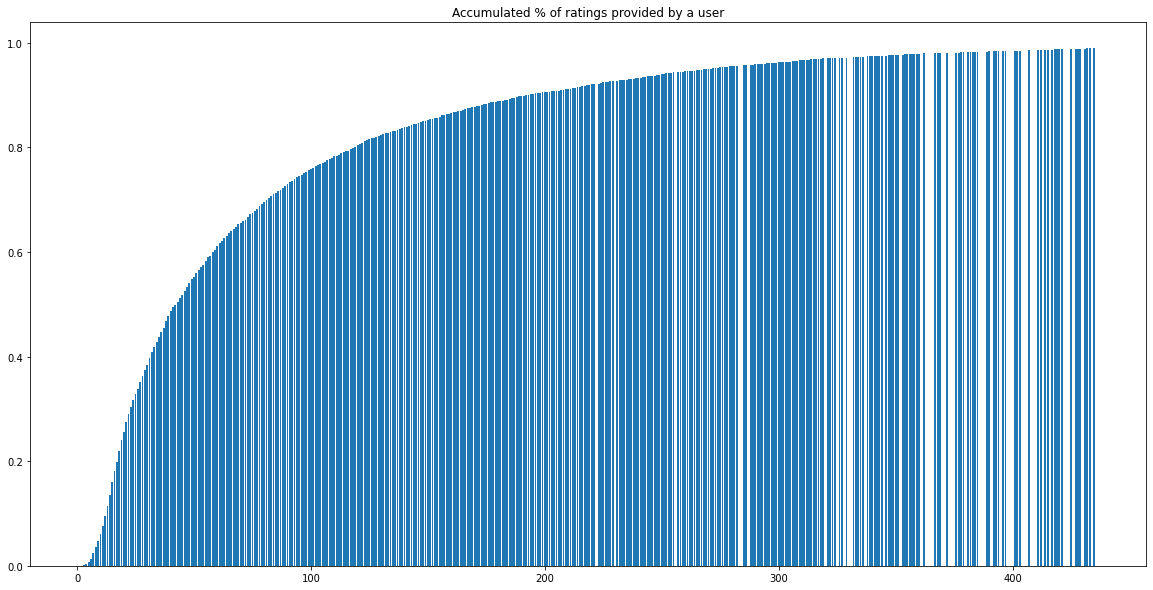

In [40]:
# 곡선의 모양으로 볼때, 적은 rating에 숫자가 몰려있는걸 확인할 수 있다. 
plt.figure(figsize=(20, 10))   

ax = plt.subplot()
ax.bar(rating_count_cumsum_99.index, height=rating_count_cumsum_99)
ax.set_title('Accumulated % of ratings provided by a user')

plt.show()

In [46]:
#435개의 review 
rating_count_cumsum_99

2      0.000166
3      0.000828
4      0.003146
5      0.006788
6      0.013245
         ...   
429    0.988742
431    0.988907
432    0.989404
433    0.989570
435    0.989735
Length: 387, dtype: float64

In [49]:
rating_to_keep = rating_n[rating_n <= 435]
rating_to_keep

UserId
1        34
2        66
3        31
4         7
5        83
       ... 
6036    189
6037     56
6038     14
6039     46
6040    168
Length: 5978, dtype: int64

In [50]:
rating_to_drop = rating_n[rating_n > 435]
rating_to_drop

UserId
195     712
424     715
549     447
710     649
752     637
       ... 
5605    499
5636    448
5643    490
5812    542
5831    580
Length: 62, dtype: int64

In [51]:
rating_to_keep = rating_n[rating_n <= 435].index

In [53]:
data = data[data['UserId'].isin(rating_to_keep)]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
...,...,...,...,...
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000167,6040,161,3,997454486


#### Rating 
* Rating이 3이하이면 사람들이 안 볼 확률이 크므로, 제거해준다. 

In [54]:
avg_rating = data.groupby('ItemId')['Rating'].mean()
avg_rating.head()

ItemId
1    4.134553
2    3.196491
3    3.061644
4    2.688742
5    3.043825
Name: Rating, dtype: float64

In [55]:
keep_rating = avg_rating[avg_rating >= 3].index

In [57]:
data = data[data['ItemId'].isin(keep_rating)]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
...,...,...,...,...
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000167,6040,161,3,997454486


#### movies 
적게 본 영화 제외시키기 
* 영화의 총 개수는 3,706
* 리뷰가 5개 미만이면 제외한다. 

In [58]:
item_n = data.groupby('ItemId').size()

In [59]:
item_n.head()

ItemId
1    1858
2     570
3     438
5     251
6     827
dtype: int64

In [60]:
item_n.describe()

count    2580.000000
mean      147.336047
std       221.452489
min         1.000000
25%        17.000000
50%        65.000000
75%       187.000000
max      2390.000000
dtype: float64

In [61]:
item_to_keep = item_n[item_n >= 5].index

In [63]:
data = data[data['ItemId'].isin(item_to_keep)]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
24,1,2340,3,978300103
36,1,1836,5,978300172
3,1,3408,4,978300275
...,...,...,...,...
999923,6040,232,5,997454398
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000167,6040,161,3,997454486


#### Time
* time의 형식을 datetime 객체로 변환후 년/월/일로 바꿔준다. 
* data 내의 time 기간을 살펴본다. (2000년 4월 25일부터 2003년 2월 28일까지)

In [71]:
from datetime import datetime

data['Time_dt'] = data['Time'].apply(lambda x : datetime.fromtimestamp(x))
data.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UserId,ItemId,Rating,Time,Time_dt
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43


In [72]:
data['Time_dt'].min(), data['Time_dt'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:08'))

In [73]:
data.drop(columns=['Time'], inplace=True)
data.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,UserId,ItemId,Rating,Time_dt
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35


In [75]:
data = data.rename(columns={'Time_dt':'Time'})
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35


### Train, validation, test set  만들기
* val portion: 6.7% (last 90 days)
* test portion: 3.9% (last 30 days)

In [74]:
print(len(data))

379564


In [84]:
from datetime import timedelta

In [85]:
def split(data:pd.DataFrame, n_days:int):
    last_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max()
    user_train = user_last_time[user_last_time < last_time - timedelta(n_days)].index
    user_test = user_last_time[user_last_time >= last_time - timedelta(n_days)].index
    
    before_date = data[data['UserId'].isin(user_train)]
    after_date = data[data['UserId'].isin(user_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [92]:
train, test = split(data, n_days=30)
train, validation = split(train, n_days=90)

In [93]:
def sets_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [94]:
sets_info(train, 'train')
sets_info(validation, 'valid')
sets_info(test, 'test')

* train Set Stats Info
	 Events: 339052
	 Sessions: 5738
	 Items: 2324
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-10-29 23:24:51

* valid Set Stats Info
	 Events: 25637
	 Sessions: 162
	 Items: 2058
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-01-29 03:00:40

* test Set Stats Info
	 Events: 14875
	 Sessions: 78
	 Items: 1979
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:08



In [95]:
total = len(train) + len(validation) + len(test)
validation_per = len(validation)/total
print('val portion:', validation_per)
test_per = len(test)/total
print('test portion:', test_per)

val portion: 0.06754328650767723
test portion: 0.0391897018684596


In [96]:
# train set에 없는 아이템이 생길 수 있으므로 train data를 기준으로 인덱싱
idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def index(df, idx):
    df['item_idx'] = df['ItemId'].map(lambda x: idx.get(x, -1))  #모르는 값(-1) 처리 
    return df

train = index(train, idx)
validation = index(validation, idx)
test = index(test, idx)

#### 데이터 파이프라인 구축 

In [97]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
validation.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 미니 배치 
Session-Parallel Mini-Batch이용, 학습 속도의 저하가 최소화될 수 있도록 만들어줌. 

#### Userdataset

In [98]:
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [99]:
tr_dataset = UserDataset(train)

#### Userdataloader

In [100]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing user-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the users to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where User Start
        end : Index Where User End
        mask : indicator for the users to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Users
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 User Index를 가져옵니다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 User Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 user가 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]  # user가 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # user의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 User가 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 User 개수만큼 새로운 User을 돌것입니다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 User이 마지막 User index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_user, finished

In [101]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=50)

In [102]:
iter_ex = iter(tr_data_loader)

In [103]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  33  42  34  35 190   1  34 260 211  33 497  26 520 527 327 569 421
 643  11 199  49 217 436  33  42 671   6 881 481 889 436 476 982  73 613
 335 812 209  22   6  79  34 628 467   6  26  90 421 139]
Label Item Idx are :       [   1   34   93   16  117  191   99  216  261  300  335  498  501  521
   33  120  267  588   42  139  135   34   42  328   90  779  288  868
  882   16  890  190  608  852  990   26  190  139  296 1050 1053   10
  865   80  666  421 1098  286  268  583]
Previous Masked Input Idx are []


### 모델 구성 

#### evaluation metric
* 모델 성능에 대한 지표로 precision이나 recall이 있습니다.   
* Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭한 n개의 아이템이 많아야 좋습니다.    
* 이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용합니다.   
* 추천에서는 몇 번째로 맞추느냐도 중요합니다.    
* 따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용합니다.    
* 여기서는 MRR과 Recall@k를 사용하겠습니다. MRR은 정답 아이템이 나온 순번의 역수 값입니다.    

In [104]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### model architecture

In [106]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [112]:
class Args:
    def __init__(self, train, validation, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.train = train
        self.validation = validation
        self.test = test
        self.num_items = train['ItemId'].nunique()
        self.num_sessions = train['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, validation, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [113]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(50, 1, 2324)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      356400    
_________________________________________________________________
dropout_1 (Dropout)          (50, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (50, 2324)                118524    
Total params: 474,924
Trainable params: 474,924
Non-trainable params: 0
_________________________________________________________________


### 모델 학습

In [116]:
def train_model(model, args):
    train_dataset = UserDataset(args.train)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.train) - args.train['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 user은 hidden_state를 초기화

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.validation, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\n\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  
    hidden_states = gru_layer.states[0].numpy()  
    for elt in mask:  
        hidden_states[elt, :] = 0  
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  
                                             
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr


In [117]:
train_model(model, args)

Train:   0%|          | 0/6666 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.71]


	 - Recall@20 epoch 1: 0.182344
	 - MRR@20    epoch 1: 0.047008




Train:   0%|          | 0/6666 [00:00<?, ?it/s, accuracy=0.02, train_loss=6.15]


	 - Recall@20 epoch 2: 0.196708
	 - MRR@20    epoch 2: 0.051257




Evaluation:  79%|███████▉  | 401/509 [02:02<00:32,  3.28it/s]


	 - Recall@20 epoch 3: 0.205337
	 - MRR@20    epoch 3: 0.054655




### 모델 테스트 
* k=20 
* recall과 MRR이 학습할때와 비슷하게 안정적으로 나왔다. 

In [118]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  57%|█████▋    | 167/295 [00:49<00:38,  3.34it/s]

	 - Recall@20: 0.194850
	 - MRR@20: 0.053632

